In [1]:
print("strawberry")

import torch
import numpy as np
import torch.nn.functional as F

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_DDU import HyperMapp3rDDU
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_SSN import HyperMapp3rSSN


# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.per_individual_losses import (
    log_cosh_dice_loss,
    TverskyLoss,
    FocalTverskyLoss,
    DiceLossMetric
)
from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
import argparse

import torch.nn as nn
import torch
from torchmetrics import Metric
import math
import seaborn as sns

print("banana")

strawberry
banana


In [2]:
torch.manual_seed(1307)

In [3]:
def get_transforms():
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        RandomAffine(p=0.2, shear=(-18,18)),
        RandomAffine(p=0.2, degrees=15),
        RandomAffine(p=0.2, translate=(-0.1,0.1)),
        RandomAffine(p=0.2, scale=(0.9, 1.1)),
#         #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))

#         #RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
            
    ]
    transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
    return PairedCompose(transforms)

def none_transform():
    transforms = [
        LabelSelect(label_id=1),
        lambda x, y: (x, y.squeeze().type(torch.long))
    ]
    return PairedCompose(transforms)

def train_val_test_split(dataset, val_prop, test_prop, seed):
        # I think the sklearn version might be prefereable for determinism and things
        # but that involves fiddling with the dataset implementation I think....
        size = len(dataset)
        test_size = int(test_prop*size) 
        val_size = int(val_prop*size)
        train_size = size - val_size - test_size
        train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
        return train, val, test

In [4]:
import torch
import torch.nn as nn
from trustworthai.models.uq_models.drop_UNet import normalization_layer
import torch.nn.functional as F
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
import torch.distributions as td
from typing import Tuple
from torch.utils.data import Dataset

In [26]:
ckpt_dir = None
is3D = False
root_dir = "/disk/scratch/s2208943/ipdis/preprep/out_data/collated/"
#root_dir = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

ednames = ["domainA", "domainB", "domainC", "domainD"]
domains = [ed_dir + d for d in ednames]
# domains = [ wmh_dir + d for d in ['Singapore', 'GE3T', 'Utrecht']]

train_proportion = 0.7
test_proportion = 0.15
validation_proportion = 0.15
seed = 3407

In [6]:
### 3d to 2d dataset
class MRISegDataset2DFrom3D(Dataset):
    def __init__(self, dataset3D, transforms=None):
        # calculate total number of slices (note need to iterate through every item
        # because each image may have a different number of slices
        size = 0
        for data in dataset3D:
            x = data[0]
            size += x.shape[1]
            
        self.size = size
        self.dataset3D = dataset3D
        self.transforms = transforms
        
        idx_to_scan_index = []
        scan_starting_index = []
        
        scan_count = 0
        starting_index = 0
        for (ind, _) in dataset3D:
            d_size = ind.shape[1] # slices are the second dim of 3D scan
            idx_to_scan_index.append(torch.ones(d_size) * scan_count)
            scan_starting_index.append(starting_index)
            
            scan_count += 1
            starting_index += d_size
            
        self.idx_to_scan = torch.cat(idx_to_scan_index, dim=0).type(torch.int32)
        # print(self.idx_to_scan.shape)
        self.scan_starting_index = scan_starting_index
        
    def __getitem__(self, idx):
        # find out which scan to use
        scan_idx = self.idx_to_scan[idx]
        # get that dataset
        scan_img, scan_label = self.dataset3D[scan_idx]
        # find out where the element is in that dataset
        item_idx = idx - self.scan_starting_index[scan_idx]
        
        #print(scan_img.shape, scan_label.shape)
        slice_x = scan_img[:, item_idx]
        slice_y = scan_label[:, item_idx] # slices are the second dim of a 3D scan (its channels, z, x, y for 3D scans)
        
        if self.transforms:
            slice_x, slice_y = self.transforms(slice_x, slice_y)
        
        return slice_x, slice_y
        
    def __len__(self):
        return self.size

In [7]:
### empty slice splitting
class FilteredEmptyElementsDataset(Dataset):
    def __init__(self, dataset, seed, transforms=None, empty_proportion_retained=0.1):
        # print(len(dataset))
        self.base_dataset = dataset
        self.transforms = transforms
        empty_indices = []
        self.non_empty_indices = []
        count = 0
        for i, (x, y) in enumerate(dataset):
            if y.sum() == 0:
                count += 1
                empty_indices.append(i)
            else:
                self.non_empty_indices.append(i)
           
        # print(count)
        # print(len(self.non_empty_indices))
        #print(count * empty_proportion_retained)
                
        # extract only a limited proportion of empty slices (take a random selection)
        shuffled_indices = torch.randperm(count, generator=torch.Generator().manual_seed(seed))
        emtpy_indices = torch.Tensor(empty_indices)
        self.retained_empty_indices = torch.Tensor(empty_indices)[shuffled_indices[0:int(count * empty_proportion_retained)]]
        self.size = len(self.non_empty_indices) + len(self.retained_empty_indices)
        self.non_empty_size = len(self.non_empty_indices)
        
            
    def __getitem__(self, idx):
        if idx >= self.non_empty_size:
            # select an empty slice
            new_idx = self.retained_empty_indices[idx - self.non_empty_size]
        else:
            # select a slice with label in it
            new_idx = self.non_empty_indices[idx]
        new_idx = int(new_idx)
        
        img, label = self.base_dataset[new_idx]
        
        if self.transforms:
            img, label = self.transforms(img, label)
            
        return img, label

    def __len__(self):
        return self.size

In [8]:
datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=None) for domain in domains]

# split into train, val test datasets
datasets_3d = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset_3d = ConcatDataset([ds[0] for ds in datasets_3d])
val_dataset_3d = ConcatDataset([ds[1] for ds in datasets_3d])
test_dataset_3d = ConcatDataset([ds[2] for ds in datasets_3d])

In [9]:
datasets_2d = [MRISegDataset2DFrom3D(ds, transforms=None) for ds in [train_dataset_3d, val_dataset_3d, test_dataset_3d]]

In [10]:
train_dataset, val_dataset, test_dataset = [FilteredEmptyElementsDataset(ds, seed=seed, transforms=get_transforms()) for ds in datasets_2d]

In [18]:
chal_names = ["Singapore", "Utrecht", "GE3T"]
domains_chal = [wmh_dir + d for d in chal_names
          ]

In [12]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
datasets_domains_chal = [MRISegmentation3DDataset(root_dir, domain, transforms=None) for domain in domains_chal]
wmh_dataset = ConcatDataset(datasets_domains_chal)

### Dataset distribution information

- summary of lesion cluster sizes in 2d axial slices per dataset and per domain
- plot of voxel intensity distribution per domain
- summary of wmh damage scores

In [27]:
### voxel intensity of WMH lesions in FLAIR
intensities_domains = {}
def extract_WMH_intensities(dss, names):
    for ds in range(len(dss)):
        intensities = []
        for x, y in dss[ds]:
            voxels = y.view(-1)
            flair = x[0].view(-1)
            wmh_intensities = flair[voxels == 1]
            intensities.append(wmh_intensities)
        intensities_domains[names[ds]] = torch.cat(intensities, dim=0)
        
extract_WMH_intensities(datasets_domains_chal, chal_names)
extract_WMH_intensities(datasets_domains, ednames)

<AxesSubplot:ylabel='Count'>

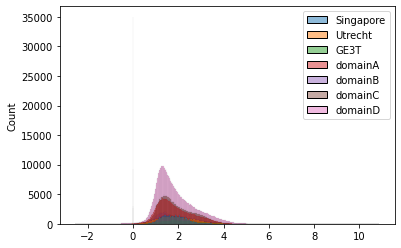

In [28]:
sns.histplot(intensities_domains)
# this looks wierd, is there a bug in my preprocessing?

In [31]:
its = intensities_domains['Singapore']

In [32]:
# lets do frequencies of -10 to 10

tensor([1.7276, 2.2272, 2.1717,  ..., 1.1104, 1.4574, 1.4574])

In [39]:
bin_width = 1/50

In [47]:
bins = np.arange(-5, 11, bin_width)
bins = torch.Tensor(bins).round(decimals=2)

In [45]:
torch.round(its, decimals=2)

tensor([1.7300, 2.2300, 2.1700,  ..., 1.1100, 1.4600, 1.4600])

In [51]:
from tqdm import tqdm

In [66]:
all_intensities_domains = {}
def extract_all_voxels_intensities(dss, names):
    domain_intensity_bins = torch.zeros(len(bins))
    for ds in range(len(dss)):
        for x, y in tqdm(dss[ds], position=0, leave=True):
            voxels = y.view(-1)
            flair = x[0].view(-1)
            
            # extract the intensities for each bin
            for i, b in enumerate(bins):
                domain_intensity_bins[i] += (torch.round(flair, decimals=2) == b).sum()
                
        all_intensities_domains[names[ds]] = domain_intensity_bins
    
extract_all_voxels_intensities(datasets_domains_chal, chal_names)
extract_all_voxels_intensities(datasets_domains, ednames)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [05:24<00:00,  2.90s/it]


In [67]:
all_intensities_domains.keys()

dict_keys(['Singapore', 'Utrecht', 'GE3T', 'domainA', 'domainB', 'domainC', 'domainD'])

In [73]:
torch.where(bins == 0)

(tensor([250]),)

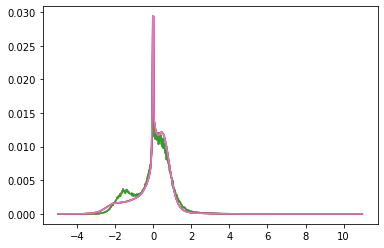

In [89]:
# ignore the 0 bin (thats background)

for d in chal_names + ednames:
# for d in chal_names[::-1]:
    sel_bins = torch.cat([bins[0:250], bins[251:]])
    bin_values = torch.cat([all_intensities_domains[d][0:250], all_intensities_domains[d][251:]])
    total = torch.sum(bin_values)
    plt.plot(sel_bins, bin_values/total, label=d)
    #plt.legend()
    # break

In [90]:
print("after normalizing, I find that the voxel intensity distributions are very similar")

after normalizing, I find that the voxel intensity distributions are very similar


In [94]:
import kornia as K

In [104]:
domain_num_lesions = {}
domain_lesion_sizes = {}

def compute_connected_component_sizes(dss, names):
    for ds in range(len(dss)):
        conncomp_outs = []
        for x, y in tqdm(dss[ds], position=0, leave=True):
            labels_out = K.contrib.connected_components(y.squeeze().unsqueeze(1).type(torch.float32), num_iterations=150)
            conncomp_outs.append(labels_out)
            
        num_lesions = 0
        sizes = []
        # per individual
        for batch, (x, y) in tqdm(enumerate(dss[ds]), position=0, leave=True):
            # per slice
            # print(y.shape)
            for i in range(0, y.squeeze().shape[0]):
                conncomps = conncomp_outs[batch][i]
                ids = conncomps.unique()[1:]
                # print(ids)
                
                # per WMH cluster (connected component)
                for idx in ids:
                    cc = (conncomps == idx)
                    num_lesions += 1
                    size = torch.sum(cc)
                    sizes.append(size)
                    # print(size)
                    
        domain_num_lesions[names[ds]] = num_lesions
        domain_lesion_sizes[names[ds]] = sizes
        
        
compute_connected_component_sizes(datasets_domains_chal, chal_names)
compute_connected_component_sizes(datasets_domains, ednames)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:34<00:00,  1.73s/it]
20it [00:01, 19.20it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:34<00:00,  1.74s/it]
20it [00:01, 17.08it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:58<00:00,  2.95s/it]
20it [00:01, 12.99it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [01:14<00:00,  1.46s/it]
51it [00:02, 18.94it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [97]:
print("hi")

hi


In [106]:
domain_num_lesions

{'Singapore': 2883,
 'Utrecht': 4136,
 'GE3T': 3016,
 'domainA': 10798,
 'domainB': 7131,
 'domainC': 10460,
 'domainD': 29272}

In [108]:
for d in domain_lesion_sizes.keys():
    print(len(domain_lesion_sizes[d]), domain_num_lesions[d])

2883 2883
4136 4136
3016 3016
10798 10798
7131 7131
10460 10460
29272 29272


In [129]:
plt.style.use('fivethirtyeight')

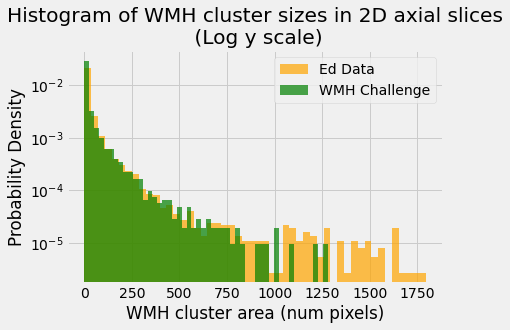

In [150]:
plt.title("Histogram of WMH cluster sizes in 2D axial slices\n (Log y scale)")

dd = 'domainC'
plt.hist(domain_lesion_sizes[dd], bins=50, density=True, label = "Ed Data", alpha=0.7, color='orange');
plt.yscale('log');

dd = 'Utrecht'
plt.hist(domain_lesion_sizes[dd], bins=50, density=True, label="WMH Challenge", alpha=0.7, color='g');
plt.yscale('log');


plt.xlabel("WMH cluster area (num pixels)")
plt.ylabel("Probability Density")
plt.legend();
plt.savefig("inplace_plots/wmh_cluster_size_histogram", bbox_inches = "tight")